In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using ForwardDiff
using BenchmarkTools

In [2]:
function cov_matr(smpl_tmp)
    smp_fl, w = flatview(unshaped.(smpl_tmp.v)), smpl_tmp.weight
    smp_fl = smp_fl ./ std(smp_fl, FrequencyWeights(w), 2)
    smp_fl = smp_fl .- mean(smp_fl, FrequencyWeights(w), dims=2)
    cov_m = cov(smp_fl, FrequencyWeights(w), 2)
    return cov_m
end

prior_ang = NamedTupleDist(
    θ = [10^-15 .. 10^-4 for i in 1:50],
    α = [0 .. 2*pi  for i in 1:50],
    x_alignm = [-200 .. 200 for i in 1:3],
    y_alignm = [-200 .. 200 for i in 1:3],
    σ = [6.23, 32.9, 35.1],
);

In [3]:
@load "../../data/sampling_results/Benchmark-9/mcmc-summary-data.jld" summary_data

1-element Array{Symbol,1}:
 :summary_data

In [4]:
smpl_tmp = bat_read("../../data/sampling_results/Benchmark-9/samples-1-50-2.hdf5")
samples_1 = varshape(prior_ang).(smpl_tmp)
ind_1 = 1:50;

In [5]:
smpl_tmp = bat_read("../../data/sampling_results/Benchmark-9/samples-51-100-2.hdf5")
samples_2 = varshape(prior_ang).(smpl_tmp)
ind_2 = 51:100;

In [6]:
smpl_tmp = bat_read("../../data/sampling_results/Benchmark-9/samples-101-150.hdf5")
samples_3 = varshape(prior_ang).(smpl_tmp)
ind_3 = 101:150;

# Plots: 

## Azimutal angle: 

In [7]:
function construct_hist(ind_tmp, samples_tmp)
    hist_array_tmp = Histogram[]
    for (ind, val) in enumerate(ind_tmp)
        smpl_x = []
        for smpl in samples_tmp.v
            push!(smpl_x, smpl.α[ind])
        end
        hist_tmp = fit(Histogram, smpl_x, FrequencyWeights(samples_tmp.weight), range(0, stop=2*pi, length=100))
        hist_tmp = normalize(hist_tmp, mode=:pdf)
        push!(hist_array_tmp, hist_tmp)
    end 
    return hist_array_tmp
end

construct_hist (generic function with 1 method)

In [8]:
hist_array = Histogram[]

append!(hist_array, construct_hist(ind_1, samples_1))
append!(hist_array, construct_hist(ind_2, samples_2))
# append!(hist_array, construct_hist(ind_3, samples_3));


In [9]:
charge_n = summary_data.ev_charge ./ maximum(summary_data.ev_charge);
charge_n[sortperm(charge_n)] .= 1:length(charge_n);
charge_n = charge_n ./ maximum(charge_n);

In [10]:
event_ind = summary_data.ev_index ./ maximum(summary_data.ev_index);

event_ind[sortperm(event_ind)] .= 1:length(event_ind);
event_ind = event_ind ./ maximum(event_ind);

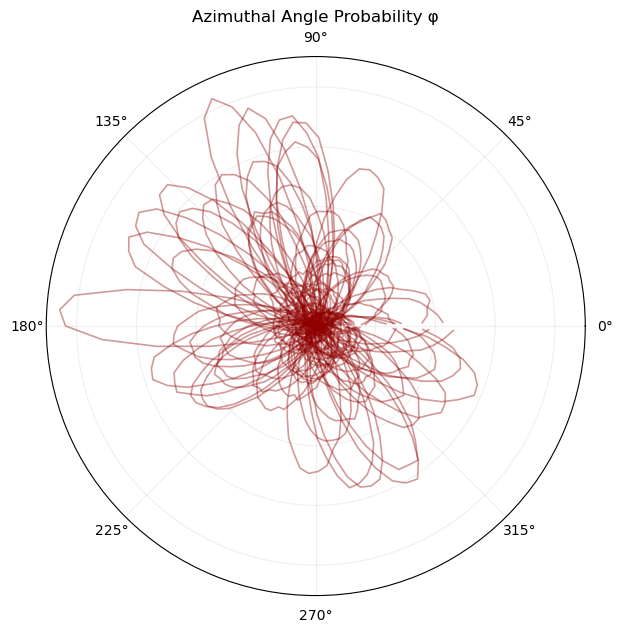

PyObject Text(0.5, 1.05, 'Azimuthal Angle Probability φ')

In [11]:
fig = figure(figsize=(7,7))

ax = PyPlot.axes(polar="true") # Create a polar axis

for i in eachindex(hist_array)
    ax.plot(midpoints(hist_array[i].edges[1]), 
        hist_array[i].weights, 
        lw=1.2,  "o-", 
        color= plt.cm.hot_r(0.8), #"k", #plt.cm.hot_r(charge_n[i]), 
        alpha=0.4, 
        marker="None") 
end


ax.grid(alpha=0.2)
ax.set_yticklabels([])
ax.set_title("Azimuthal Angle Probability φ")

## Polar angle:

In [12]:
function construct_log_hist(ind_tmp, samples_tmp)
    hist_array_tmp = Histogram[]
    for ind in 1:50
        smpl_x = []
        for smpl in samples_tmp.v
            push!(smpl_x, log.(smpl.θ[ind]))
        end
        hist_tmp = fit(Histogram, smpl_x, FrequencyWeights(samples_tmp.weight), range(-19, stop=-8, length=150))
        hist_tmp = normalize(hist_tmp, mode=:pdf)
        push!(hist_array_tmp, hist_tmp)
    end 
    return hist_array_tmp
end

construct_log_hist (generic function with 1 method)

In [13]:
hist_array = Histogram[]

append!(hist_array, construct_log_hist(ind_1, samples_1))
append!(hist_array, construct_log_hist(ind_2, samples_2))
# append!(hist_array, construct_hist(ind_3, samples_3));


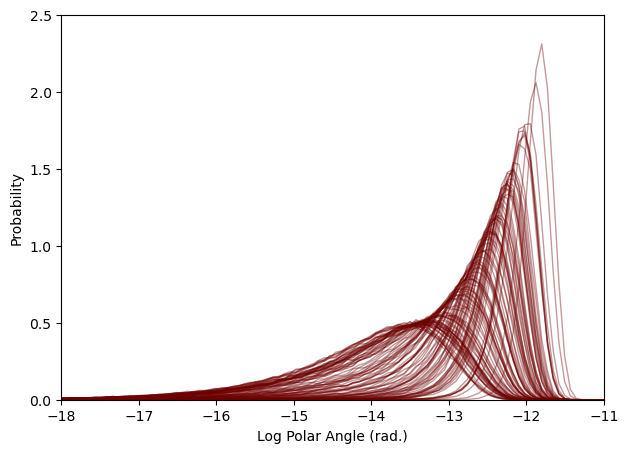

PyObject Text(24.000000000000007, 0.5, 'Probability')

In [14]:
fig, ax= plt.subplots(1,1, figsize=(7,5), )

for i in eachindex(hist_array)
    ax.plot(midpoints(hist_array[i].edges[1]), 
        hist_array[i].weights, 
        lw=1.0,  "o-", 
        color= plt.cm.hot_r(0.85),  #"k",  #plt.cm.hot_r(charge_n[i]), 
        alpha=0.4, 
        marker="None")
end
ax.set_xlim(-18, -11)

ax.set_ylim(0, 2.5)
ax.set_xlabel("Log Polar Angle (rad.)")
ax.set_ylabel("Probability")


## Waist Position:

In [15]:
function predict_position(x0, y0, θ, α, s)
    x_expected = x0 .+ cos(α).*θ.*s.*10^6
    y_expected = y0 .+ sin(α).*θ.*s.*10^6
    return (x_expected, y_expected)
end

predict_position (generic function with 1 method)

In [16]:
function construct_waist_hist(ind_run, samples_tmp, init_data)
    array_tmp = []
    
    for (ind, val) in enumerate(ind_run)
        x_init = summary_data.μx_align[val][1]
        y_init = summary_data.μy_align[val][1]
        
        x_position = Float64[]
        y_position = Float64[]
        
        for smpl in samples_tmp.v
            pred_x, pred_y = predict_position(x_init, y_init, smpl.θ[ind], smpl.α[ind], 2.9)
            push!(x_position, pred_x)
            push!(y_position, pred_y)
        end
        
        x_mean = mean(x_position, FrequencyWeights(samples_tmp.weight))
        y_mean = mean(y_position, FrequencyWeights(samples_tmp.weight))
        
        x_std = std(x_position, FrequencyWeights(samples_tmp.weight))
        y_std = std(y_position, FrequencyWeights(samples_tmp.weight))
        
        hist_tmp = fit(Histogram, (x_position,y_position), FrequencyWeights(samples_tmp.weight), nbins=30) 
#         hist_tmp = normalize(hist_tmp, mode=:pdf)
        
        push!(array_tmp, (μ=[x_mean, y_mean], σ=[x_std, y_std], hist=hist_tmp))
    end 
    return array_tmp
end

construct_waist_hist (generic function with 1 method)

In [17]:
hist_array = []

append!(hist_array, construct_waist_hist(ind_1, samples_1, summary_data))
append!(hist_array, construct_waist_hist(ind_2, samples_2, summary_data));


In [18]:
μ_x = [i.μ[1] for i in hist_array]
μ_y = [i.μ[2] for i in hist_array]

σ_x = [i.σ[1] for i in hist_array]
σ_y = [i.σ[2] for i in hist_array]

μ_x = μ_x .- minimum(μ_x)
μ_y = μ_y .- minimum(μ_y);

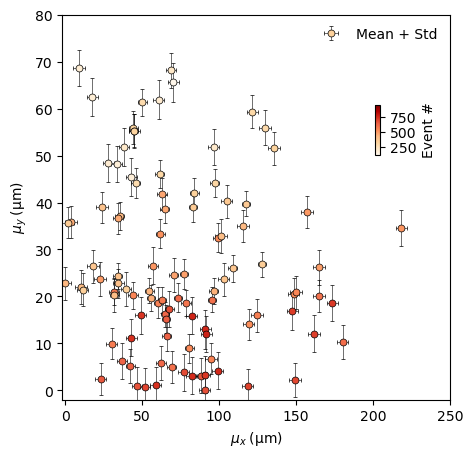

(-2.0, 80.0)

In [19]:
fig, ax= plt.subplots(1,1, figsize=(5,5), )

label = "Mean + Std"
for i in eachindex(hist_array)
    
    ax.errorbar(μ_x[i], μ_y[i], xerr=σ_x[i], yerr=σ_y[i], 
        mfc=plt.cm.OrRd(event_ind[i]), #red
        fmt="o", 
        markersize = 5, 
        markeredgecolor = "k", 
        markeredgewidth=0.5, 
        capsize=1.5, 
        ecolor="k", elinewidth=0.4, label=label)
    label=""
end

cb = ax.scatter(event_ind, event_ind, s=0.0, c=summary_data.ev_index, cmap="OrRd")
ax_ins_3 = fig.add_axes([0.75,0.6,0.01,0.1])
fig.colorbar(cb, spacing="proportional", label="Event #", cax=ax_ins_3)

ax.set_xlabel(L"\mu_x \; \mathrm{(\mu m)}")
ax.set_ylabel(L"\mu_y \; \mathrm{(\mu m)}")

ax.legend(loc="upper right", framealpha=0.0)

ax.set_xlim(-2,250)
ax.set_ylim(-2,80)